<a href="https://colab.research.google.com/github/virarkh/customer-segmentation-using-RFM-K-Means/blob/master/Skripsi_Segmentasi_Pelanggan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [3]:
pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 23.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import datetime as dt
from datetime import datetime
from datetime import timedelta
from datetime import time

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

import plotly.io as pio
pio.renderers.default = 'iframe'
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px

import feature_engine
from feature_engine.outliers import Winsorizer
from scipy.stats.mstats import winsorize

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Data Understanding

### Data Profiling

In [5]:
# Mengakses dataset dari spreadsheet
sheet_id = '1-rPoksqtegeqEkaFvGGMlpcFqfxx1gai-SicUizB4q4'
xls = pd.ExcelFile(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx')

df = pd.read_excel(xls, 'Dataset')

df.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1,10000
1,065321010200000076,2021-01-02 15:18:40,1,10000
2,065321010600000078,2021-01-06 15:28:17,1,10000
3,065321010600000078,2021-01-06 15:28:17,1,10000
4,065321010800000080,2021-01-08 09:39:05,1,10000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_no    457 non-null    object        
 1   order_time  457 non-null    datetime64[ns]
 2   qty         457 non-null    int64         
 3   amount      457 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 14.4+ KB


In [7]:
# export raw data of df dataframe
# df.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\raw_data.csv')

### Exploratory Data Analysis

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
qty,457.0,3.345733,6.558003,1.0,1.0,2.0,3.0,75.0
amount,457.0,33457.330416,65580.027079,10000.0,10000.0,20000.0,30000.0,750000.0


In [9]:
df_monthly = df.copy()
df_monthly.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1,10000
1,065321010200000076,2021-01-02 15:18:40,1,10000
2,065321010600000078,2021-01-06 15:28:17,1,10000
3,065321010600000078,2021-01-06 15:28:17,1,10000
4,065321010800000080,2021-01-08 09:39:05,1,10000


In [10]:
# Mengubah format tanggal transaksi
df_monthly['order_time'] = pd.to_datetime(df_monthly['order_time'], format='%Y-%m-%d')

# Mengelompokkan data berdasarkan bulan dan tahun
df_monthly = df_monthly.set_index('order_time').resample('M').sum().reset_index()

df_monthly

,order_time,qty,amount
0,2021-01-31,100,1000000
1,2021-02-28,140,1400000
2,2021-03-31,176,1760000
3,2021-04-30,79,790000
4,2021-05-31,103,1030000
5,2021-06-30,0,0
6,2021-07-31,50,500000
7,2021-08-31,230,2300000
8,2021-09-30,32,320000
9,2021-10-31,240,2400000


In [11]:
# export df_monthly dataframe
# df_monthly.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\monthly_sales.csv')

In [12]:
# Membuat linechart menggunakan pyplot
plot_order = [
    go.Scatter(
        x = df_monthly['order_time'],
        y = df_monthly['qty'],
        mode = 'lines+markers'
    )
]

plot_layout = go.Layout(
#     xaxis = {'type': 'category', 'tickformat': '%Y/%m'},
    xaxis = {'tickformat': '%Y-%m-%d'},
    xaxis_title = 'Bulan',
    yaxis_title = 'Jumlah Penjualan',
    title = 'Tren Penjualan Energy Bar di Bulan Januari 2021 - Februari 2022'
)

fig = go.Figure(data=plot_order, layout=plot_layout)
fig.update_layout(plot_layout)
fig.show()

# Data Preparation

### Data Cleansing

In [13]:
# Mengubah tipe data pada kolom qty dan price dari float ke int
df[['qty', 'amount']] = df[['qty', 'amount']].astype(float).astype(int)

df.head()

,order_no,order_time,qty,amount
0,065321010200000076,2021-01-02 15:18:40,1,10000
1,065321010200000076,2021-01-02 15:18:40,1,10000
2,065321010600000078,2021-01-06 15:28:17,1,10000
3,065321010600000078,2021-01-06 15:28:17,1,10000
4,065321010800000080,2021-01-08 09:39:05,1,10000


In [14]:
dataset = df.copy()

### RFM Scoring

In [15]:
# Mengidentifikasi timebound dari tanggal awal dan tanggal terakhir transaksi
print(dataset['order_time'].min())
print(dataset['order_time'].max())

2021-01-02 15:18:40
2022-02-24 16:08:23


In [16]:
# Menetapkan tanggal yang akan digunakan untuk menghitung recency
now = dt.date(2022, 2, 24)
dataset['Date'] = pd.DatetimeIndex(dataset.order_time).date

In [17]:
# Menghitung nilai Recency
df_recency = dataset.groupby(['order_no'],as_index=False)['Date'].max()
df_recency.columns = ['order_no','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(now - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,order_no,Recency
0,065321010200000076,418
1,065321010600000078,414
2,065321010800000080,412
3,065321010800000082,412
4,065321010800000085,412


In [18]:
# Menghitung nilai Frequency & Monetary
df_fm = dataset.groupby('order_no').agg({'order_no':lambda x:len(x),
                                    'amount':lambda x:sum(x)})
df_fm.rename(columns = {'order_no' :'Frequency',
                        'amount':'Monetary'},inplace= True)
df_fm.head()

,Frequency,Monetary
order_no,,
065321010200000076,2,20000
065321010600000078,2,20000
065321010800000080,1,10000
065321010800000082,2,200000
065321010800000085,2,100000


In [19]:
# Menggabungkan nilai RFM dengan order no
RFM_Table = df_recency.merge(df_fm,left_on='order_no',right_on='order_no')
RFM_Table.head()

,order_no,Recency,Frequency,Monetary
0,065321010200000076,418,2,20000
1,065321010600000078,414,2,20000
2,065321010800000080,412,1,10000
3,065321010800000082,412,2,200000
4,065321010800000085,412,2,100000


In [20]:
# Menghapus kolom order no untuk transformasi
RFM_Table_New = RFM_Table.drop(['order_no'], axis=1)

In [21]:
# RFM_Table_New = RFM_Table.copy()

In [22]:
RFM_Table_New.head()

,Recency,Frequency,Monetary
0,418,2,20000
1,414,2,20000
2,412,1,10000
3,412,2,200000
4,412,2,100000


In [23]:
RFM_Table_New.describe()

,Recency,Frequency,Monetary
count,260.000000,260.000000,2.600000e+02
mean,220.753846,1.757692,5.880769e+04
std,125.227796,0.429306,1.196509e+05
min,0.000000,1.000000,1.000000e+04
25%,115.000000,2.000000,2.000000e+04
50%,201.000000,2.000000,3.000000e+04
75%,338.250000,2.000000,4.000000e+04
max,418.000000,2.000000,1.500000e+06


In [24]:
# RFM_Table.to_csv(r'C:\Users\ACER\SKRIPSI\data_rfm.csv')

### Deteksi Outlier

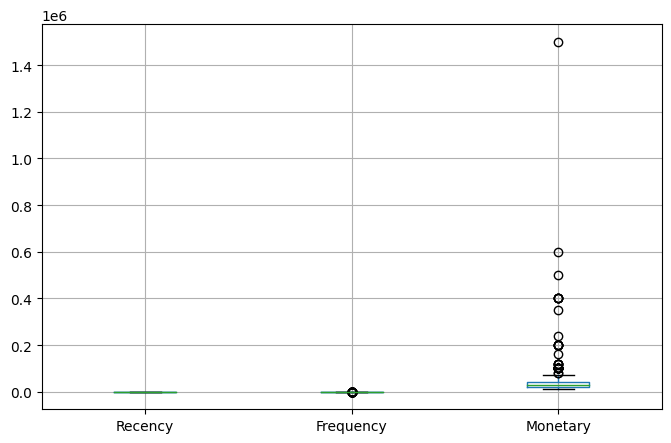

In [25]:
# Mengidentifikasi outlier menggunakan boxplot
plt.figure(figsize=(8, 5))
RFM_Table_New.boxplot()
plt.show()

In [26]:
# Mengidentifikasi batas atas dan batas bawah untuk outlier untuk kolom Frequency
Q1_frequency = RFM_Table_New['Frequency'].quantile(0.25)
Q3_frequency = RFM_Table_New['Frequency'].quantile(0.75)
IQR_frequency = Q3_frequency - Q1_frequency
lower_bound_frequency = Q1_frequency - 1.5 * IQR_frequency
upper_bound_frequency = Q3_frequency + 1.5 * IQR_frequency

In [27]:
# Mengidentifikasi batas atas dan batas bawah untuk outlier untuk kolom Monetary
Q1_monetary = RFM_Table_New['Monetary'].quantile(0.25)
Q3_monetary = RFM_Table_New['Monetary'].quantile(0.75)
IQR_monetary = Q3_monetary - Q1_monetary
lower_bound_monetary = Q1_monetary - 1.5 * IQR_monetary
upper_bound_monetary = Q3_monetary + 1.5 * IQR_monetary

In [28]:
# Mengidentifikasi baris data yang merupakan outlier berdasarkan batas atas dan batas bawah
outliers_frequency = RFM_Table_New[(RFM_Table_New['Frequency'] < lower_bound_frequency) | (RFM_Table_New['Frequency'] > upper_bound_frequency)]
outliers_monetary = RFM_Table_New[(RFM_Table_New['Monetary'] < lower_bound_monetary) | (RFM_Table_New['Monetary'] > upper_bound_monetary)]

In [29]:
print(outliers_frequency)

     Recency  Frequency  Monetary
2        412          1     10000
14       364          1     20000
15       362          1     40000
16       362          1     20000
17       362          1     20000
..       ...        ...       ...
242       21          1     10000
244       15          1     10000
246       14          1     50000
254        2          1     10000
259       86          1    500000

[63 rows x 3 columns]


In [30]:
print(outliers_monetary)

     Recency  Frequency  Monetary
3        412          2    200000
4        412          2    100000
7        409          2    100000
11       408          2    200000
13       393          2    100000
19       237          2    120000
21       230          2    100000
22       230          2    100000
40       198          2    600000
57       189          2    100000
60       181          2    400000
63       180          2    200000
67       146          2    100000
68       143          2    100000
76       133          2   1500000
77       133          2    120000
100      100          2    240000
105       94          2    120000
115       77          2    350000
119       75          2    160000
120       69          2    200000
122       66          2     80000
123       63          2    100000
131       49          2    400000
146      381          2    200000
155      374          1    100000
157      373          2    200000
160      369          2    100000
161      369  

In [31]:
# Menghitung batas atas dan batas bawah untuk setiap variabel
q1 = RFM_Table_New.quantile(0.25)
q3 = RFM_Table_New.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

In [32]:
lower_bound

Recency       -219.875
Frequency        2.000
Monetary    -10000.000
dtype: float64

In [33]:
upper_bound

Recency        673.125
Frequency        2.000
Monetary     70000.000
dtype: float64

In [34]:
# Winsorize data menggunakan batas atas dan batas bawah yang sudah dihitung
data_winsorized = pd.DataFrame()
for col in RFM_Table_New.columns:
    data_winsorized[col] = winsorize(RFM_Table_New[col], limits=0.05)
#     data_winsorized[col] = winsorize(RFM_Table_New[col], limits=(lower_bound[col], upper_bound[col]))

In [35]:
# Menampilkan data asli dan data yang sudah di-winsorize
print('Data Asli:')
print(RFM_Table_New)

print('\nData Winsorized:')
print(data_winsorized)

Data Asli:
     Recency  Frequency  Monetary
0        418          2     20000
1        414          2     20000
2        412          1     10000
3        412          2    200000
4        412          2    100000
..       ...        ...       ...
255        2          2     30000
256        0          2     40000
257      300          2     20000
258      121          2    120000
259       86          1    500000

[260 rows x 3 columns]

Data Winsorized:
     Recency  Frequency  Monetary
0        406          2     20000
1        406          2     20000
2        406          1     10000
3        406          2    200000
4        406          2    100000
..       ...        ...       ...
255       17          2     30000
256       17          2     40000
257      300          2     20000
258      121          2    120000
259       86          1    200000

[260 rows x 3 columns]


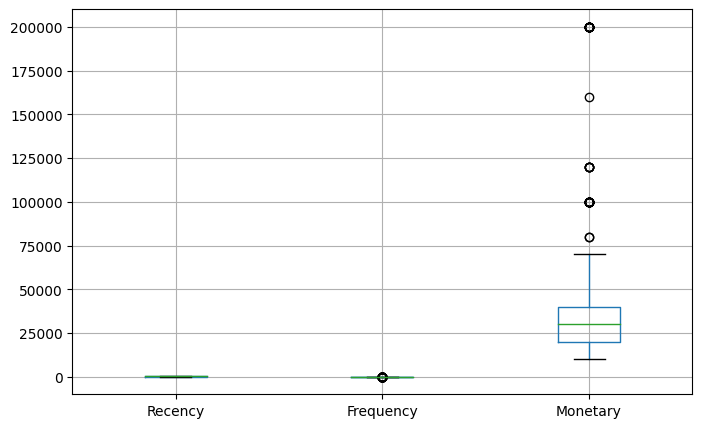

In [36]:
# Mengidentifikasi outlier setelah dilakukan winsorizer
plt.figure(figsize=(8, 5))
data_winsorized.boxplot()
plt.show()

In [37]:
df_rfm = data_winsorized.copy()

In [38]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,260.000000,260.000000,260.000000
mean,221.011538,1.757692,46538.461538
std,124.076433,0.429306,48286.652727
min,17.000000,1.000000,10000.000000
25%,115.000000,2.000000,20000.000000
50%,201.000000,2.000000,30000.000000
75%,338.250000,2.000000,40000.000000
max,406.000000,2.000000,200000.000000


In [39]:
df_rfm.shape

(260, 3)

In [40]:
# export preprocessing data of df dataframe
# df_rfm.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\preprocessing_data.csv')

### Transformasi Data

In [41]:
df_rfm_new = df_rfm.copy()
df_rfm_new.head()

,Recency,Frequency,Monetary
0,406,2,20000
1,406,2,20000
2,406,1,10000
3,406,2,200000
4,406,2,100000


In [42]:
df_rfm_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    260 non-null    int64
 1   Frequency  260 non-null    int64
 2   Monetary   260 non-null    int64
dtypes: int64(3)
memory usage: 6.2 KB


In [43]:
df_rfm_new = np.log(df_rfm_new+1)

In [44]:
windsoriser = Winsorizer(tail='both',
                         fold=2,
                         variables=['Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_new)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [45]:
df_rfm_new = windsoriser.transform(df_rfm_new)

In [46]:
# Melakukan transformasi data menggunakan standard scaler
scaler = StandardScaler()
scaler.fit(df_rfm_new)
df_rfm_scaled = scaler.transform(df_rfm_new)

In [47]:
df_rfm_scaled = pd.DataFrame(df_rfm_scaled, columns=df_rfm.columns)
df_rfm_scaled.head()

,Recency,Frequency,Monetary
0,1.084883,0.565506,-0.574239
1,1.084883,0.565506,-0.574239
2,1.084883,-1.768328,-1.446730
3,1.084883,0.565506,2.079966
4,1.084883,0.565506,1.451719


In [48]:
df_rfm_scaled.shape

(260, 3)

In [49]:
df_rfm_scaled = df_rfm_scaled.round(6)

df_rfm_scaled.head()

,Recency,Frequency,Monetary
0,1.084883,0.565506,-0.574239
1,1.084883,0.565506,-0.574239
2,1.084883,-1.768328,-1.446730
3,1.084883,0.565506,2.079966
4,1.084883,0.565506,1.451719


In [50]:
# export standar scaller data of df dataframe
df_rfm_scaled.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\scaler.csv')

# Modeling

In [51]:
X = np.asarray(df_rfm_scaled)

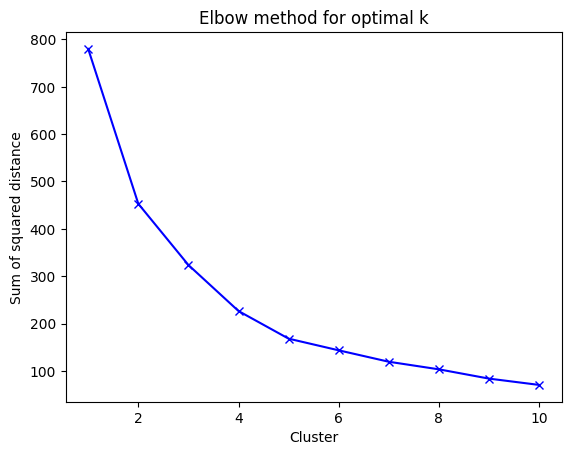

In [52]:
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')
plt.title('Elbow method for optimal k')
plt.show()

In [53]:
# Menampilkan nilai SSE untuk setiap jumlah kluster
for k, sse in zip(K, Sum_of_squared_distances):
    print("Number of clusters:", k)
    print("SSE:", sse)
    print("\n")

Number of clusters: 1
SSE: 780.0000776044142


Number of clusters: 2
SSE: 452.94908692291466


Number of clusters: 3
SSE: 323.63242592960376


Number of clusters: 4
SSE: 226.40910103775528


Number of clusters: 5
SSE: 168.0318729651254


Number of clusters: 6
SSE: 143.38248604726076


Number of clusters: 7
SSE: 119.2634893789984


Number of clusters: 8
SSE: 103.23923463129508


Number of clusters: 9
SSE: 83.65815736052231


Number of clusters: 10
SSE: 70.31788496941718




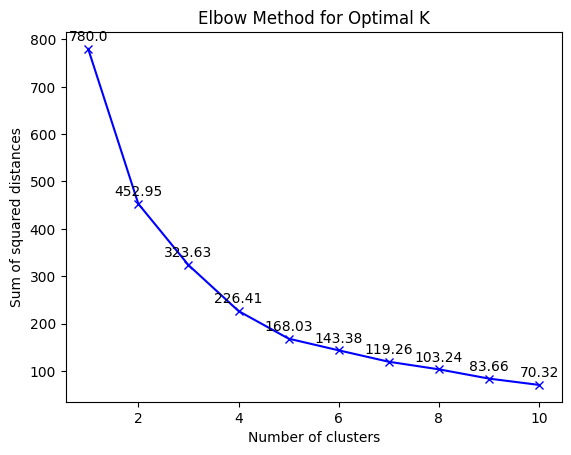

In [54]:
# Plot elbow graph with SSE values
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for Optimal K')
# plt.show()

# Add SSE values as text above each cluster point
for k, sse in zip(K, Sum_of_squared_distances):
    plt.text(k, sse + 10, str(round(sse, 2)), ha='center', va='bottom')

plt.show()

# Evaluation

In [55]:
model_kmeans_2 = KMeans(n_clusters = 2)
model_kmeans_2.fit(X)

KMeans(n_clusters=2)

In [56]:
model_kmeans_3 = KMeans(n_clusters = 3)
model_kmeans_3.fit(X)

KMeans(n_clusters=3)

In [57]:
model_kmeans_4 = KMeans(n_clusters = 4)
model_kmeans_4.fit(X)

KMeans(n_clusters=4)

In [58]:
model_kmeans_5 = KMeans(n_clusters = 5)
model_kmeans_5.fit(X)

KMeans(n_clusters=5)

In [59]:
model_kmeans_6 = KMeans(n_clusters = 6)
model_kmeans_6.fit(X)

KMeans(n_clusters=6)

In [60]:
model_kmeans_7 = KMeans(n_clusters = 7)
model_kmeans_7.fit(X)

KMeans(n_clusters=7)

In [61]:
model_kmeans_8 = KMeans(n_clusters = 8)
model_kmeans_8.fit(X)

KMeans()

In [62]:
model_kmeans_9 = KMeans(n_clusters = 9)
model_kmeans_9.fit(X)

KMeans(n_clusters=9)

In [63]:
model_kmeans_10 = KMeans(n_clusters = 10)
model_kmeans_10.fit(X)

KMeans(n_clusters=10)

<hr>

In [64]:
# Menghitung nilai davies bouldin score

In [65]:
print(davies_bouldin_score(X, model_kmeans_2.labels_))

0.900800347164028


In [66]:
print(davies_bouldin_score(X, model_kmeans_3.labels_))

0.9998353977930693


In [67]:
print(davies_bouldin_score(X, model_kmeans_4.labels_))

0.7653054819296347


In [68]:
print(davies_bouldin_score(X, model_kmeans_5.labels_))

0.7995082017245391


In [69]:
print(davies_bouldin_score(X, model_kmeans_6.labels_))

0.8835367066230595


In [70]:
print(davies_bouldin_score(X, model_kmeans_7.labels_))

0.8248327546490107


In [71]:
print(davies_bouldin_score(X, model_kmeans_8.labels_))

0.8551959274416032


In [72]:
print(davies_bouldin_score(X, model_kmeans_9.labels_))

0.7463390205509977


In [73]:
print(davies_bouldin_score(X, model_kmeans_10.labels_))

0.7142555011551137


# Deployment

In [74]:
# Melakukan labeling dengan 4 cluster
df_clustered = pd.DataFrame(RFM_Table)
df_clustered['cluster'] = pd.DataFrame(model_kmeans_4.labels_)
df_clustered = df_clustered.sort_values('cluster')
data_clustered = np.asarray(df_clustered)

data_clustered

array([['065321010200000076', 418, 2, 20000, 0],
       ['E39421042900000250', 301, 2, 20000, 0],
       ['E39421042900000251', 301, 2, 20000, 0],
       ...,
       ['E39421053100000431', 269, 2, 400000, 3],
       ['E39421091400000469', 163, 2, 80000, 3],
       ['OL22010500000078', 86, 1, 500000, 3]], dtype=object)

In [75]:
cluster_labels = model_kmeans_4.labels_

In [76]:
rfm_labels_4 = RFM_Table.assign(cluster = cluster_labels)

rfm_labels_4.head()

,order_no,Recency,Frequency,Monetary,cluster
0,065321010200000076,418,2,20000,0
1,065321010600000078,414,2,20000,0
2,065321010800000080,412,1,10000,1
3,065321010800000082,412,2,200000,3
4,065321010800000085,412,2,100000,3


In [77]:
rfm_labels_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 259
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   order_no   260 non-null    object
 1   Recency    260 non-null    int64 
 2   Frequency  260 non-null    int64 
 3   Monetary   260 non-null    int64 
 4   cluster    260 non-null    int32 
dtypes: int32(1), int64(3), object(1)
memory usage: 11.2+ KB


In [78]:
# export dataframe after clustering
# rfm_labels_4.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\all_cluster_data.csv')

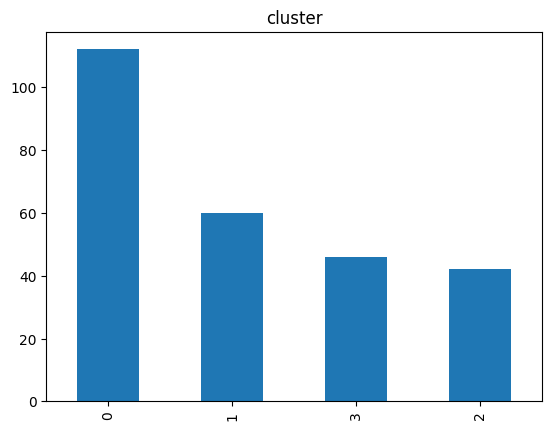

In [79]:
rfm_labels_4['cluster'].value_counts().plot(kind='bar');
plt.title('cluster');

In [80]:
df_clustered

,order_no,Recency,Frequency,Monetary,cluster
0,065321010200000076,418,2,20000,0
206,E39421042900000250,301,2,20000,0
207,E39421042900000251,301,2,20000,0
208,E39421042900000252,301,2,20000,0
209,E39421042900000253,301,2,20000,0
...,...,...,...,...,...
185,E39421032900000184,332,2,70000,3
225,E39421052700000424,273,2,100000,3
226,E39421053100000431,269,2,400000,3
232,E39421091400000469,163,2,80000,3


In [81]:
cluster_0 = df_clustered.loc[df_clustered['cluster'] == 0]

cluster_0.head()

,order_no,Recency,Frequency,Monetary,cluster
0,065321010200000076,418,2,20000,0
206,E39421042900000250,301,2,20000,0
207,E39421042900000251,301,2,20000,0
208,E39421042900000252,301,2,20000,0
209,E39421042900000253,301,2,20000,0


In [82]:
# export cluster 0 dataframe
cluster_0.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\cluster_0.csv')

In [83]:
cluster_1 = df_clustered.loc[df_clustered['cluster'] == 1]

cluster_1.head()

,order_no,Recency,Frequency,Monetary,cluster
138,7EC621022200000006,367,1,20000,1
189,E39421040100000199,329,1,10000,1
140,E39421013000000014,390,1,10000,1
188,E39421033100000196,330,1,10000,1
2,065321010800000080,412,1,10000,1


In [84]:
# export cluster 1 dataframe
# cluster_1.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\cluster_1.csv')

In [85]:
cluster_2 = df_clustered.loc[df_clustered['cluster'] == 2]

cluster_2.head()

,order_no,Recency,Frequency,Monetary,cluster
256,E39422022400000584,0,2,40000,2
246,E39422021000000541,14,1,50000,2
243,E39422020700000516,17,2,20000,2
237,E39422020300000501,21,2,40000,2
248,E39422021500000566,9,2,50000,2


In [86]:
# export cluster 2 dataframe
# cluster_2.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\cluster_2.csv')

In [87]:
cluster_3 = df_clustered.loc[df_clustered['cluster'] == 3]

cluster_3.head()

,order_no,Recency,Frequency,Monetary,cluster
3,065321010800000082,412,2,200000,3
4,065321010800000085,412,2,100000,3
7,065321011100000092,409,2,100000,3
11,065321011200000099,408,2,200000,3
13,065321012700000103,393,2,100000,3


In [88]:
# export cluster 3 dataframe
# cluster_3.to_csv(r'C:\Users\ACER\SKRIPSI\dataset\cluster_3.csv')

In [89]:
cluster_0.shape

(112, 5)

In [90]:
cluster_1.shape

(60, 5)

In [91]:
cluster_2.shape

(42, 5)

In [92]:
cluster_3.shape

(46, 5)

In [93]:
cluster_0.describe()

,Recency,Frequency,Monetary,cluster
count,112.000000,112.0,112.000000,112.0
mean,268.982143,2.0,29732.142857,0.0
std,89.592871,0.0,10777.004333,0.0
min,126.000000,2.0,20000.000000,0.0
25%,190.000000,2.0,20000.000000,0.0
50%,289.000000,2.0,20000.000000,0.0
75%,343.500000,2.0,40000.000000,0.0
max,418.000000,2.0,50000.000000,0.0


In [94]:
cluster_1.describe()

,Recency,Frequency,Monetary,cluster
count,60.000000,60.0,60.000000,60.0
mean,222.500000,1.0,16500.000000,1.0
std,134.893618,0.0,10865.120683,0.0
min,2.000000,1.0,10000.000000,1.0
25%,112.000000,1.0,10000.000000,1.0
50%,190.000000,1.0,10000.000000,1.0
75%,362.000000,1.0,20000.000000,1.0
max,412.000000,1.0,50000.000000,1.0


In [95]:
cluster_2.describe()

,Recency,Frequency,Monetary,cluster
count,42.000000,42.000000,42.000000,42.0
mean,57.833333,1.976190,36428.571429,2.0
std,38.182435,0.154303,20579.581234,0.0
min,0.000000,1.000000,20000.000000,2.0
25%,14.750000,2.000000,20000.000000,2.0
50%,62.500000,2.000000,35000.000000,2.0
75%,90.000000,2.000000,40000.000000,2.0
max,119.000000,2.000000,100000.000000,2.0


In [96]:
cluster_3.describe()

,Recency,Frequency,Monetary,cluster
count,46.000000,46.000000,4.600000e+01,46.0
mean,249.804348,1.956522,2.052174e+05,3.0
std,117.660268,0.206185,2.338826e+05,0.0
min,49.000000,1.000000,7.000000e+04,3.0
25%,135.500000,2.000000,1.000000e+05,3.0
50%,271.000000,2.000000,1.000000e+05,3.0
75%,350.500000,2.000000,2.000000e+05,3.0
max,412.000000,2.000000,1.500000e+06,3.0
